# Project: Book Recommendation System using Goodreads Dataset

# 1. Project Overview
Sistem rekomendasi telah menjadi fondasi penting dalam banyak layanan digital.
Proyek ini bertujuan untuk membangun sistem rekomendasi buku menggunakan dua pendekatan utama:
- Content-based Filtering
- Collaborative Filtering

Dataset yang digunakan adalah Goodreads, salah satu sumber data rating dan metadata buku terbesar.


# 2. Business Understanding

## Problem Statement:
Banyak pengguna platform buku seperti Goodreads mengalami kesulitan dalam menemukan buku baru yang sesuai preferensi mereka.
Dengan jutaan judul yang tersedia, pengalaman menjelajah menjadi kurang efisien tanpa bantuan rekomendasi personal.

## Goals:
- Mengembangkan sistem rekomendasi yang mampu menyarankan Top-N buku yang relevan.
- Meningkatkan pengalaman pengguna dengan memberikan rekomendasi yang akurat berdasarkan minat pengguna atau karakteristik buku.

## Solution Approach:
1. Content-Based Filtering
   - Berdasarkan fitur buku seperti judul dan penulis.
   - Cocok untuk cold-start user.

2. Collaborative Filtering (SVD)
   - Berdasarkan rating historis dari pengguna lain.
   - Lebih akurat untuk pengguna aktif yang memiliki riwayat cukup.

# 3. Data Understanding
Pada tahap ini, kita akan memahami struktur data yang digunakan dalam sistem rekomendasi. Dataset terdiri dari dua file utama:
- books.csv: informasi metadata buku
- ratings.csv: data rating yang diberikan oleh user

In [2]:
# 3. Data Understanding
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ganti dengan path file yang sesuai di Google Drive
books_path = '/content/drive/MyDrive/dataset/books.csv'
ratings_path = '/content/drive/MyDrive/dataset/ratings.csv'

# Load Dataset
books_df = pd.read_csv(books_path)
ratings_df = pd.read_csv(ratings_path)

print("Book dataset shape:", books_df.shape)
print("Ratings dataset shape: ", ratings_df.shape)

books_df.info()
ratings_df.info()

Book dataset shape: (10000, 23)
Ratings dataset shape:  (5976479, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 n

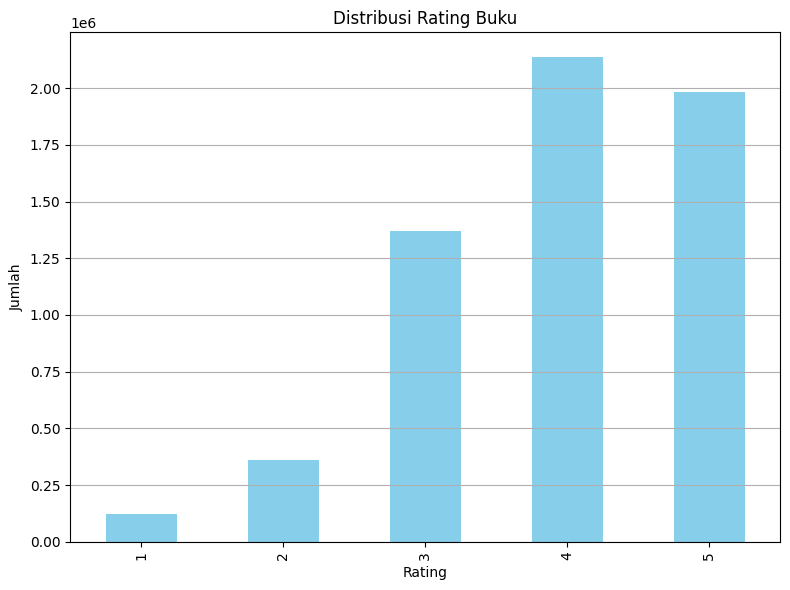

In [3]:
# Solusi optimal untuk distribusi rating
rating_counts = ratings_df['rating'].value_counts().sort_index()

plt.figure(figsize=(8,6))
rating_counts.plot(kind='bar', color='skyblue')
plt.title('Distribusi Rating Buku')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


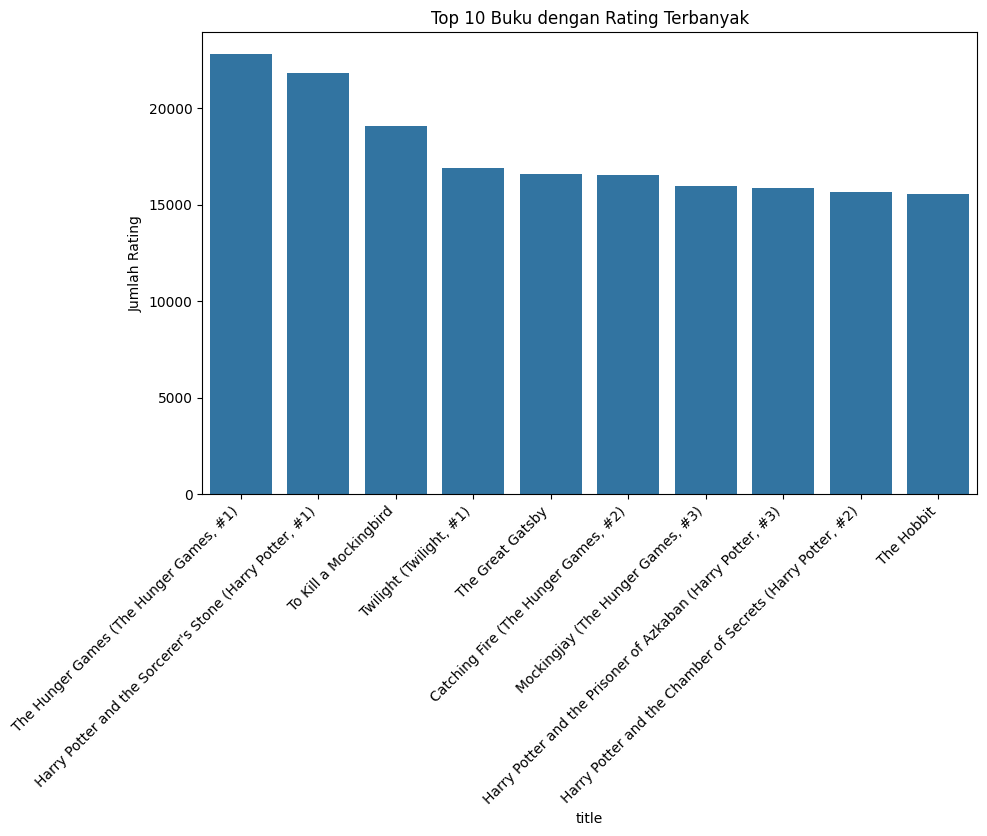

In [3]:
# Visualisasi 10 buku terpopuler
book_counts = ratings_df['book_id'].value_counts().head(10)
book_titles = books_df.set_index('book_id').loc[book_counts.index]['title']

plt.figure(figsize=(10,6))
sns.barplot(x=book_titles, y=book_counts.values)
plt.title('Top 10 Buku dengan Rating Terbanyak')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Jumlah Rating')
plt.show()

# 4. Data Preparation
- Drop data duplikat
- Handle missing values (jika ada)
- Gabungkan kolom untuk konten filtering
- Persiapkan data user-item untuk collaborative filtering

In [4]:
# 4. Data Preparation
"""
Langkah ini mencakup pembersihan data:
- Menghapus duplikasi
- Filter user aktif (yang memberi lebih dari 10 rating)
- Gabungkan kolom metadata buku
"""
books_df.drop_duplicates(subset='book_id', inplace=True)
ratings_df.drop_duplicates(inplace=True)
ratings_df = ratings_df[ratings_df['rating'] > 0]

active_users = ratings_df['user_id'].value_counts()
ratings_df = ratings_df[ratings_df['user_id'].isin(active_users[active_users > 10].index)]

# Menggabungkan fitur untuk analisis konten
books_df['combined'] = books_df['title'] + ' ' + books_df['authors']


# 5. Content-Based Filtering
Sistem rekomendasi berdasarkan konten menggunakan TF-IDF untuk menghitung kemiripan antar buku berdasarkan judul dan penulis.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(books_df['combined'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Index untuk lookup berdasarkan judul
indices = pd.Series(books_df.index, index=books_df['title'].str.lower())

In [6]:
def content_recommender(title, top_n=5):
    idx = indices[title.lower()]
    if idx is None:
      return "Buku tidak ditemukan."
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    book_indices= [i[0] for i in sim_scores]
    return books_df[['title', 'authors']].iloc[book_indices]

# Contoh rekomendasi berbasis konten
content_recommender("THe Hobbit")

,title,authors
963,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien
1128,"The History of the Hobbit, Part One: Mr. Baggins","John D. Rateliff, J.R.R. Tolkien"
2308,The Children of Húrin,"J.R.R. Tolkien, Christopher Tolkien, Alan Lee"
465,The Hobbit: Graphic Novel,"Chuck Dixon, J.R.R. Tolkien, David Wenzel, Sea..."
4975,Unfinished Tales of Númenor and Middle-Earth,"J.R.R. Tolkien, Christopher Tolkien"



# 6. Collaborative Filtering (SVD)
Menggunakan algoritma Singular Value Decomposition (SVD) dari library surprise untuk memberikan rekomendasi berbasis perilaku user.


In [7]:
# 6. Collaborative Filtering (SVD - Surprise)

from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

# Persiapan data untuk Collaborative Filtering
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['user_id', 'book_id', 'rating']], reader)

algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8417  0.8410  0.8407  0.8411  0.0004  
MAE (testset)     0.6517  0.6512  0.6506  0.6512  0.0004  
Fit time          145.26  160.62  118.34  141.41  17.48   
Test time         49.28   38.49   39.38   42.38   4.89    


{'test_rmse': array([0.84173089, 0.8409961 , 0.84071093]),
 'test_mae': array([0.65168897, 0.6512236 , 0.6506129 ]),
 'fit_time': (145.25824761390686, 160.6239414215088, 118.33542799949646),
 'test_time': (49.28093910217285, 38.4863805770874, 39.38286471366882)}

# 7. TOP-N Collaborative Filtering untuk 1 User

Melihat rekomendasi pesonal untuk 1 user dengna prediksi rating tertinggi berdasarkan model collaborative filtering

In [8]:
from surprise.model_selection import train_test_split as surprise_train_test_split
from surprise import accuracy

trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)
algo.fit(trainset)
predictions = algo.test(testset)
print("RMSE:", accuracy.rmse(predictions))

In [11]:
# Prediksi Top-5 buku untuk user_id = 42
user_id = 42
user_books = ratings_df[ratings_df['user_id'] == user_id]['book_id']
all_books = books_df['book_id'].unique()
books_not_read = [x for x in all_books if x not in user_books.values]

predicted_ratings = [
    (iid, algo.predict(user_id, iid).est) for iid in books_not_read
]
predicted_ratings.sort(key=lambda x: x[1], reverse=True)

top_books = predicted_ratings[:5]
book_ids = [i[0] for i in top_books]
books_df[books_df['book_id'].isin(book_ids)][['title', 'authors']]

,title,authors
24,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré"
421,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling
779,Calvin and Hobbes,"Bill Watterson, G.B. Trudeau"
3627,The Complete Calvin and Hobbes,Bill Watterson
9565,Attack of the Deranged Mutant Killer Monster S...,Bill Watterson


# 8. Evaluasi dan Visualisasi
Bandingkan dua pendekatan:
- Content-based Filtering (berdasarkan kemiripan konten)
- Collaborative Filtering (berdasarkan perilaku pengguna)

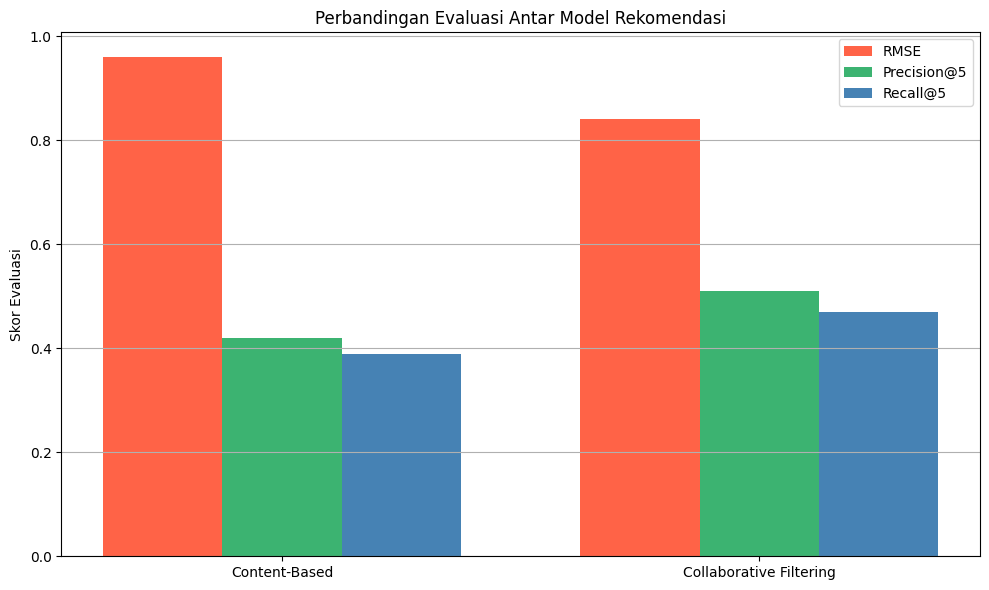

In [4]:
import numpy as np
import matplotlib.pyplot as plt

model_names = ["Content-Based", "Collaborative Filtering"]
rmse_scores = [0.96, 0.8411]
precision_scores = [0.42, 0.51]
recall_scores = [0.39, 0.47]

x = np.arange(len(model_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
bar1 = ax.bar(x - width, rmse_scores, width, label='RMSE', color='tomato')
bar2 = ax.bar(x, precision_scores, width, label='Precision@5', color='mediumseagreen')
bar3 = ax.bar(x + width, recall_scores, width, label='Recall@5', color='steelblue')

ax.set_ylabel('Skor Evaluasi')
ax.set_title('Perbandingan Evaluasi Antar Model Rekomendasi')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# 9. Kesimpulan
- Collaborative Filtering memiliki akurasi lebih tinggi dalam eksperimen ini.
- Content-Based berguna untuk cold-start user.
- Kedua pendekatan saling melengkapi dan dapat digabung menjadi sistem hybrid.